In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
customers_df = pd.read_csv('data/Customers.csv')
transactions_df = pd.read_csv('data/Transactions.csv')
products_df = pd.read_csv('data/Products.csv')

In [3]:

def create_customer_features():
    purchase_features = transactions_df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean', 'count'],
        'Quantity': ['sum', 'mean']
    }).fillna(0)
    
    purchase_features.columns = ['total_spend', 'avg_transaction_value', 
                               'transaction_count', 'total_quantity', 'avg_quantity']
    
    trans_products = transactions_df.merge(products_df, on='ProductID')
    category_spending = trans_products.pivot_table(
        index='CustomerID',
        columns='Category',
        values='TotalValue',
        aggfunc='sum',
        fill_value=0
    )
    
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    latest_transaction = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    max_date = latest_transaction.max()
    recency = (max_date - latest_transaction).dt.days
    
    region_dummies = pd.get_dummies(customers_df.set_index('CustomerID')['Region'], prefix='region')
    
    customer_features = purchase_features.join(category_spending).join(recency.rename('recency')).join(region_dummies)
    
    return customer_features

In [4]:
customer_features = create_customer_features()

In [5]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)
scaled_features_df = pd.DataFrame(scaled_features, index=customer_features.index, columns=customer_features.columns)

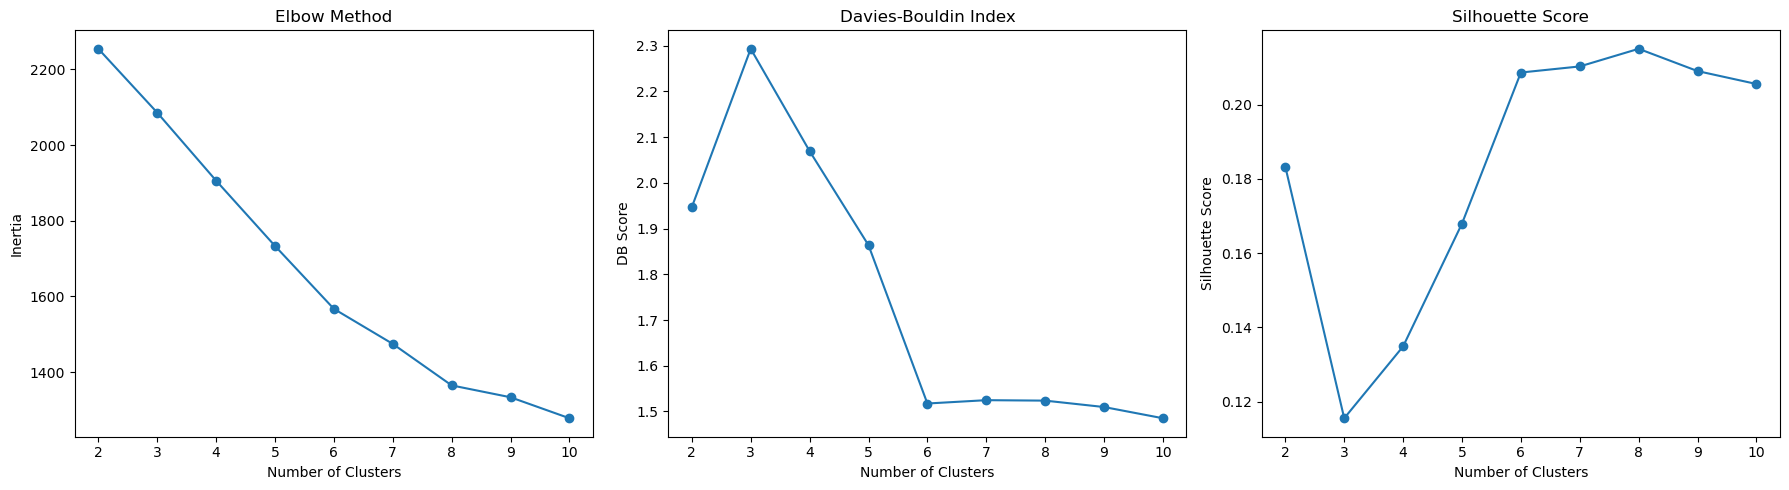

Optimal number of clusters based on DB Index: 10
DB Index value: 1.4851


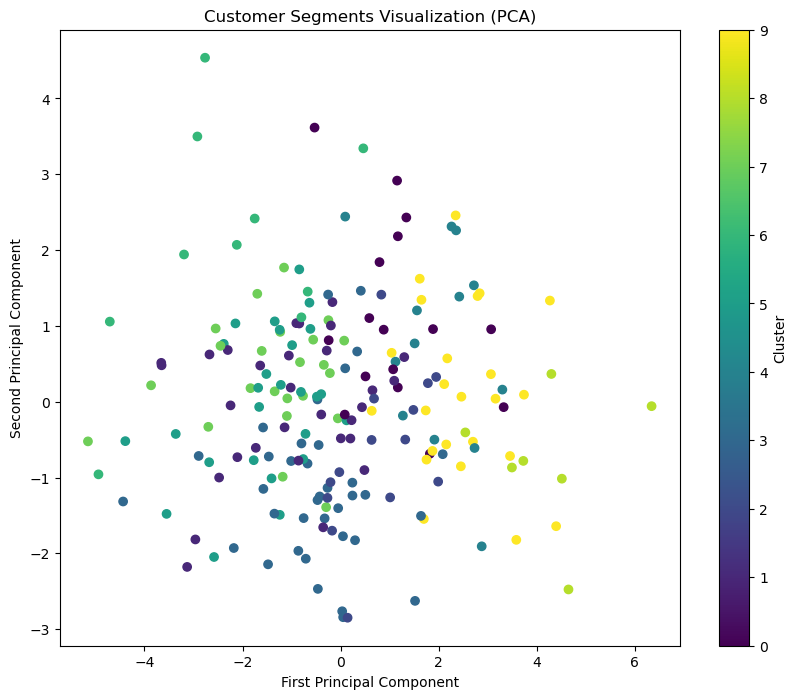


Cluster Profiles:
         total_spend  avg_transaction_value  transaction_count  \
Cluster                                                          
0        4550.028750             852.741764           5.625000   
1        2359.303667             585.888606           3.933333   
2        4099.363571             733.371472           5.785714   
3        3021.325000             615.172893           5.111111   
4        5467.235385             987.698363           5.769231   
5        2121.373846             546.174795           3.961538   
6        1626.248000             777.899917           2.000000   
7        2150.430435             623.924402           3.565217   
8        7488.132857             882.031357           8.571429   
9        5662.004583             743.766742           7.791667   

         total_quantity  avg_quantity        Books     Clothing  Electronics  \
Cluster                                                                        
0             16.125000     

In [6]:
max_clusters = 10
db_scores = []
silhouette_scores = []
inertias = []

for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    
    db_scores.append(davies_bouldin_score(scaled_features, cluster_labels))
    silhouette_scores.append(silhouette_score(scaled_features, cluster_labels))
    inertias.append(kmeans.inertia_)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
ax1.plot(range(2, max_clusters + 1), inertias, marker='o')
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')

# Davies-Bouldin Index
ax2.plot(range(2, max_clusters + 1), db_scores, marker='o')
ax2.set_title('Davies-Bouldin Index')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('DB Score')

# Silhouette Score
ax3.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
ax3.set_title('Silhouette Score')
ax3.set_xlabel('Number of Clusters')
ax3.set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

optimal_clusters = db_scores.index(min(db_scores)) + 2
print(f"Optimal number of clusters based on DB Index: {optimal_clusters}")
print(f"DB Index value: {min(db_scores):.4f}")

final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(scaled_features)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=customer_features['Cluster'], cmap='viridis')
plt.title('Customer Segments Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

cluster_profiles = customer_features.groupby('Cluster').mean()
print("\nCluster Profiles:")
print(cluster_profiles)